## Distance and Scoring Functions
If people asked me to name one thing that has been constantly ignored or not given importance in machine learning, first thing
from top of my head would be evaluation. That is partially because some contexts(search, recommender systems) it is somehow difficult to build an evaluation function that first perfectly aligns with the business logic. Partially, people end up measuring and optimizing towards wrong thing or not the _best_ thing for the business problem. 

Consider the following scenario; you are predicting the number of items sold for a variety of items in a distribution problem. Assume that most of the businesses that require these items are small businesses, so they require small number of items. Large business require large number of items but comparing to small businesses their number is much less. Further, assume that errors in the number of items sold in the prediction would result in a big problem for small businesses as they struggle to sell. However, large number of items in error for large businesses may not cause a big problem for them as they could sell somehow items easier than small businesses.

For this application $l_2$(RMSE) may not make sense, because you will have errors in small quantitites and even if you are optimizing total error to be smallest, you are not optimizing for the business logic. $l_2$ results in small errors in large number of observations(small errors for both large businesses and small businesses).

$l_1$ could be better evaluation distance function when you compute the error, even if its value may exceed $l_2$. $l_1$ produces rather sparse error distribution and if you penalize the number of items to error, it will shrink the error to large number of businesses which is an optimal state for the business logic. 

At this point, one needs to also think, maybe the evaluation function should not be the number of items to be sold, but rather $\sum p(items * \text{probability of an item is sold } |\text{ business}_i)$. 

Of course, evaluation does not really mean anything without a proper evaluation function. If you are predicting $\hat{y}$ and want to measure cost function from $y$, distance function that you will use is crucially important as it will determine the __model__. So, the distance function as well as what type of scoring function is using in the evaluation is quite important for how your model performs.

Luckily, Scikit-Learn comes with a lot of distance and scoring functions out of the box. If you want another distance and scoring function, separate from these, it is easy to build one based on your needs as well. This makes it very convenient to try different scoring methods when you do the model selection. 

### Evaluation Methods for Unsupervised Learning Algorithm
It is relatively harder problem to evaluate a learning algorithm in an unsupervised setting as there is no ground truth labels for each class and model selection is not only concerned by the model itself but also the number of classes that the model is setting in the learning algorithm. 

As in the supervised learning algorithm case, Scikit-Learn provides a variety of scoring functions out of the box to compute various metrics for a given clustering algorithm or compare multiple ones based on a single metric and preferably same number of clusters. `homogeneity_score`, `completeness_score` and `v_measure_score`(harmonic mean of `homogeneity_score` and `completeness_score`) are examples of these scores.

In [1]:
% matplotlib inline
import itertools
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn import cross_validation
from sklearn import datasets
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

plt.style.use('fivethirtyeight')

### Scoring Functions

#### Custom Metric Functions

In [2]:
metrics.SCORERS

{'accuracy': make_scorer(accuracy_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'f1': make_scorer(f1_score),
 'f1_macro': <repr(<sklearn.metrics.scorer._PredictScorer at 0x10970c110>) failed: AttributeError: 'functools.partial' object has no attribute '__name__'>,
 'f1_micro': <repr(<sklearn.metrics.scorer._PredictScorer at 0x10970c150>) failed: AttributeError: 'functools.partial' object has no attribute '__name__'>,
 'f1_samples': <repr(<sklearn.metrics.scorer._PredictScorer at 0x10970c190>) failed: AttributeError: 'functools.partial' object has no attribute '__name__'>,
 'f1_weighted': <repr(<sklearn.metrics.scorer._PredictScorer at 0x10970c1d0>) failed: AttributeError: 'functools.partial' object has no attribute '__name__'>,
 'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
 'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False

In [3]:
scoring_funcs = [ii for ii in dir(metrics) if 'score' in ii and not ii.startswith('_')]

In [4]:
scoring_funcs

['accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision_score',
 'brier_score_loss',
 'completeness_score',
 'consensus_score',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'get_scorer',
 'homogeneity_score',
 'jaccard_similarity_score',
 'label_ranking_average_precision_score',
 'make_scorer',
 'mutual_info_score',
 'normalized_mutual_info_score',
 'precision_recall_fscore_support',
 'precision_score',
 'r2_score',
 'recall_score',
 'roc_auc_score',
 'scorer',
 'silhouette_score',
 'v_measure_score']

In [5]:
_DATA_DIR = 'data'
_TRAINING_DATA_PATH = os.path.join(_DATA_DIR, 'userart-mat-training.csv')
_TEST_DATA_PATH = os.path.join(_DATA_DIR, 'userart-mat-test.csv')
_ARTIST_TAGS_PATH = os.path.join(_DATA_DIR, 'artists-tags.txt')

In [6]:
df = pd.read_csv(_TRAINING_DATA_PATH)

In [7]:
df.head(10)

ArtistID  user_000001  user_000002  \
0  c489cd1c-d8d3-4dcc-b7b9-dcf7cd95d2ed            0            0   
1  9ccbb935-33fd-4df8-ae2d-779497c5630a            0            0   
2  c71b2cc1-2737-4f76-bbf2-9ee505b4d90d            0            0   
3  0aa8294b-6332-4b65-b677-e3a1f8591d3b            0            0   
4  67673557-2310-41d3-83b9-e6e0cb1d65d5            0            0   
5  69ead53e-b2d4-45f4-b777-71363fdeff28            0            0   
6  5a092e7c-faa9-45d0-88c6-052205804e6c            0            0   
7  81fdb05d-3f73-4c38-bf69-d3c642a04439            0            0   
8  b0f475fe-ad28-4cf8-92f0-b5ca978004b1            0            0   
9  6994f98a-a41e-4d74-af5b-9e3fab3c19b4            0            0   

   user_000003  user_000004  user_000005  user_000006  user_000007  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   
6            0            0            0            0            0   
7            0            0            0            0            0   
8            0            0            0            0            0   
9            0            0            0            0            0   

   user_000008  user_000009     ...       user_000890  user_000891  \
0            0            0     ...                 0            0   
1            0            0     ...                 0            0   
2            0            0     ...                 0            0   
3            0            0     ...                 0            0   
4            0            0     ...                 0            0   
5            0            0     ...                 0            0   
6            0            0     ...                 0            0   
7            0            0     ...                 0            0   
8            0            0     ...                 0            0   
9            0            0     ...                 0            0   

   user_000892  user_000893  user_000894  user_000895  user_000896  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   
6            0            0            0            0            0   
7            0            0            0            0            0   
8            1            0            0            0            0   
9            0            0            0            0            0   

   user_000897  user_000898  user_000899  
0            0            0            0  
1            0            0            0  
2            0            1            0  
3            0            0            0  
4            0            0            0  
5            1            0            0  
6            0            0            0  
7            0            0            0  
8            0            0            0  
9            0            0            0  

[10 rows x 847 columns]

In [8]:
del df['ArtistID']

In [9]:
X = df.as_matrix().astype(float)
X.shape

(17119, 846)

In [10]:
n_artists, n_users = X.shape
frame_number = n_artists // n_users + 1

In [11]:
frame_number

21

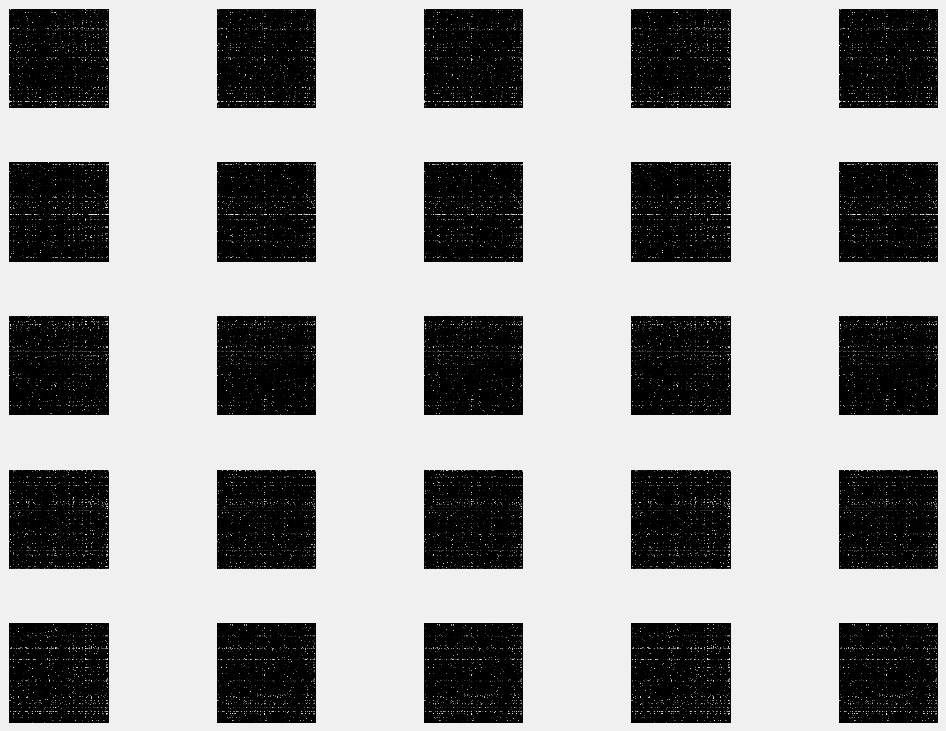

In [ ]:
col_number = row_number = 5
fig, ax = plt.subplots(row_number, col_number, figsize=(16, 12))
for ii in range(25):
    row, col = ii // row_number, ii % row_number
    indices = range((row-1)*n_users, row * n_users)
    ax[row, col].imshow(X[indices], cmap='bone')
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

### Internal Evaluation

In [ ]:
silhouette_scores = []
n_clusters = range(2, 15)

for n_cluster in n_clusters:
    print('K-Means run for number of clusters: {} is started'.format(n_cluster))
    kmeans = cluster.KMeans(n_clusters=n_cluster, init="k-means++").fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(metrics.silhouette_score(X, labels, metric='euclidean'))


K-Means run for number of clusters: 2 is started
K-Means run for number of clusters: 3 is started
K-Means run for number of clusters: 4 is started
K-Means run for number of clusters: 5 is started

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(n_clusters, silhouette_scores)
plt.ylabel("Silhouette Score");
plt.xlabel("Cluster");
plt.title("Silhouette vs Cluster Size");

### External Evaluation

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
plt.figure(figsize=(16, 12))
plt.imshow(X.reshape((30, 20)), cmap='bone')
plt.xticks([]);
plt.yticks([]);

In [ ]:
n_clusters = range(2, 15)
adjusted_random_scores = []
v_measure_scores = []

for n_cluster in n_clusters:
    print('K-Means run for number of clusters: {} is started'.format(n_cluster))
    kmeans = cluster.KMeans(n_clusters=n_cluster, init="k-means++").fit(X)
    labels = kmeans.labels_
    adjusted_random_scores.append(metrics.adjusted_rand_score(y, labels) )
    v_measure_scores.append(metrics.v_measure_score(y, labels))

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(n_clusters, adjusted_random_scores)
plt.ylabel("Adjusted Random Score");
plt.xlabel("Cluster");
plt.title("Adjusted Random Score vs Cluster Size");

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(n_clusters, v_measure_scores)
plt.ylabel("V Measure Score");
plt.xlabel("Cluster");
plt.title("V Measure Score vs Cluster Size");

### Supervised Setting

In [ ]:
df = sns.load_dataset("titanic")
df.head(10)

In [ ]:
df.dropna(inplace=True)

Turn all the columns to categorical variables!

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['embarked'] = label_encoder.fit_transform(df.embarked)
df['embark_town'] = label_encoder.fit_transform(df.embark_town)
df['alive'] = label_encoder.fit_transform(df.alive)
df['alone'] = label_encoder.fit_transform(df.alone)
df['deck'] = label_encoder.fit_transform(df.deck)
df['adult_male'] = label_encoder.fit_transform(df.adult_male)
df['who'] = label_encoder.fit_transform(df.who)
df['class'] = label_encoder.fit_transform(df['class'])
df['parch'] = label_encoder.fit_transform(df['parch'])
df['sex'] = label_encoder.fit_transform(df.sex)

In [ ]:
y = df.survived.as_matrix()
del df['survived']

In [ ]:
X = df.as_matrix().astype(float)

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.5,
                                                    random_state=2)

classifier_name_tuples = [('Sigmoid Kernel Support Vector Classifier', svm.SVC(kernel='sigmoid', probability=True, shrinking=True, gamma=.1)),
                          ('Bernoulli Naive Bayes Classifier', naive_bayes.BernoulliNB()),
                          ('RBF Kernel Support Vector Classifier', svm.SVC(kernel='rbf', probability=True)),
                          ('Extra Trees Classifier', ensemble.ExtraTreesClassifier()),
                          ('Logistic Regression', linear_model.LogisticRegression(penalty='l1', C=.1)),
                          ('Random Forest Classifier', ensemble.RandomForestClassifier()),
                          ('Multinomial Naive Bayes Classifier', naive_bayes.MultinomialNB())
                          ]

    
colors = itertools.cycle(["#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
    "dodgerblue",
    "mediumpurple",
])

fig, ax = plt.subplots(figsize=(16,12))
for clf_name, clf in classifier_name_tuples:
    clf.fit(X_train, y_train)
    probas_ = clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1], )
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors.next(), lw=2, label='ROC curve for {}'.format(clf_name))
    print('Region under curve for {0} is : {1:.2f}'.format(clf_name, roc_auc))
#    ax.annotate('AUC for {0} = {1:.2f}'.format(clf_name, roc_auc), xy=(0.35, 0.6));

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted', label='random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC curves for different classifiers');
plt.legend(loc="lower right");